In [112]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import utils

In [113]:
%matplotlib inline

In [114]:
main_path = Path.cwd() / ".."

---

Cargamos las imagenes a usar en el ejercicio.

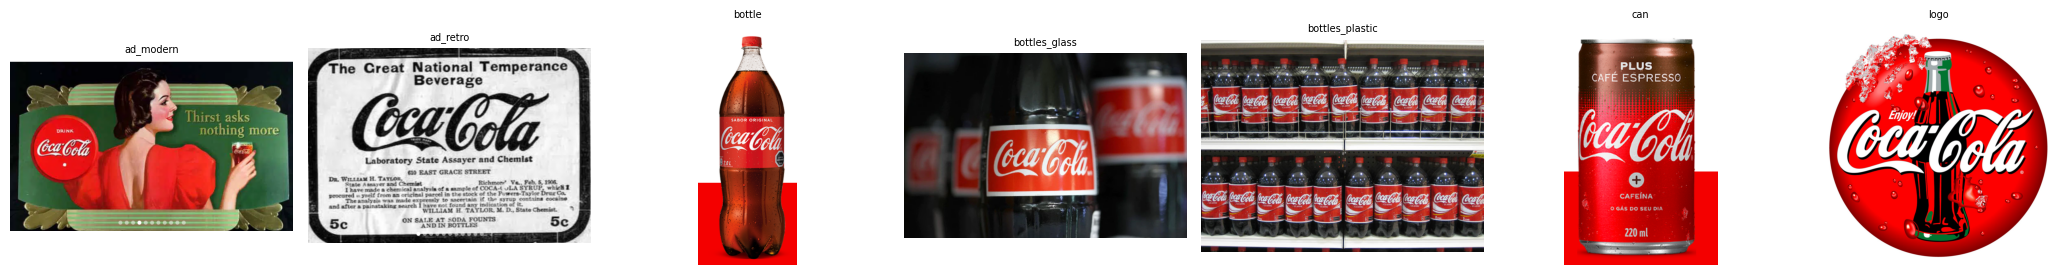

Images shape:

ad_modern:        h_429, w_715
ad_retro:         h_493, w_715
bottle:           h_500, w_207
bottles_glass:    h_450, w_687
bottles_plastic:  h_598, w_799
can:              h_363, w_233
logo:             h_1389, w_1389


In [115]:
folder_path = main_path / "data/images"

dict_imgs = {}
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    name, _ = os.path.splitext(filename)
    dict_imgs[name] = cv2.imread(file_path)

utils.plot_imgs(list(dict_imgs.values()), list(dict_imgs.keys()), rows=1, figsize=3)

print("Images shape:\n")
for name, img in dict_imgs.items():
    blank = " "
    print(f"{name}:{blank*(16-len(name))} h_{img.shape[0]}, w_{img.shape[1]}")

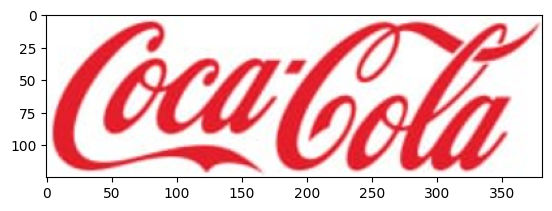

In [116]:
folder_path = main_path / "data/template"
filename = "logo_template.png"
file_path = os.path.join(folder_path, filename)

template = cv2.imread(file_path)

# Crop the template
template = template[27:152,7:388,:]
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

---

##### Ejercicio 1

Obtener una detección del logo en cada imagen sin falsos positivos.

Como podemos observar, los logos en las imagenes sobre las que vamos a buscar están en blanco sobre rojo o negro sobre blanco. Por lo cual un template con el logo en tono medio (rojo) sobre fondo blanco va a ser subóptimo para matchear.

Vamos a obtener los bordes de las imágenes y del template utilizando Canny. De esta manera vamos a poder matchear generalizando a nuevos casos en los que el logo aparezca sobre un fondo completamente diferente.

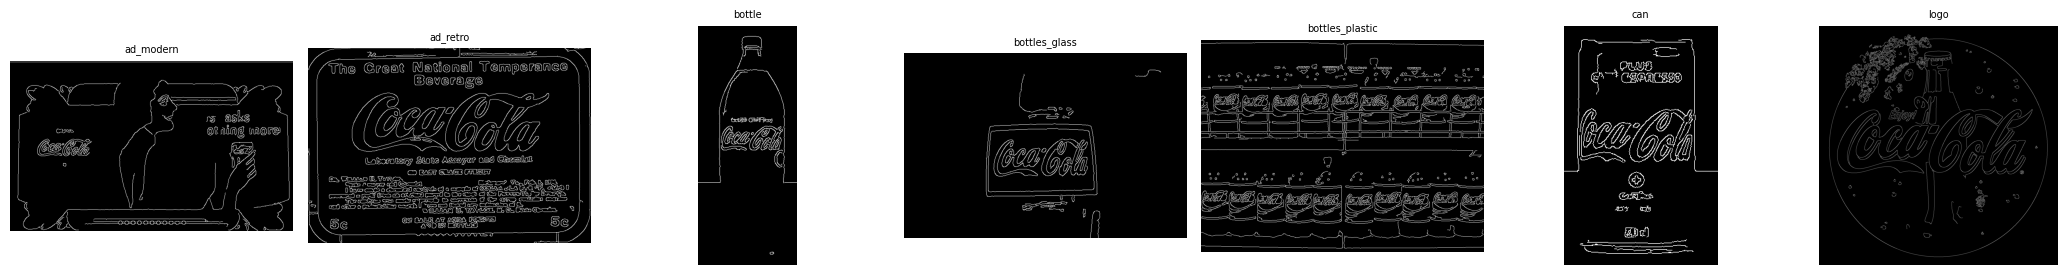

In [117]:
dict_imgs_border = {}
for name, img in dict_imgs.items():
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, ksize=(5, 5), sigmaX=3, sigmaY=3)
    # Obtain borders using Canny
    img_border = cv2.Canny(img_gray, threshold1=5, threshold2=200)

    dict_imgs_border[name] = img_border

utils.plot_imgs(list(dict_imgs_border.values()), list(dict_imgs_border.keys()), rows=1, figsize=3)

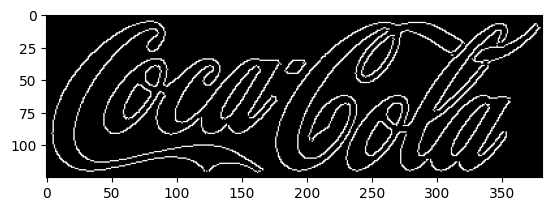

In [118]:
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# Gaussian blur to remove noise
template_gray = cv2.GaussianBlur(template_gray, ksize=(5, 5), sigmaX=3, sigmaY=3)
# Obtain borders using Canny
template_border = cv2.Canny(template_gray, threshold1=5, threshold2=200)

plt.imshow(cv2.cvtColor(template_border, cv2.COLOR_BGR2RGB))

Encontramos además logos de diversos tamaños en las imágenes sobre las que vamos a matchear. Por este motivo vamos a tener que generar templates de diversas escalas para poder matchearlos.

logo menor: h_35, w_75
ratio logo-imagen: 0.094


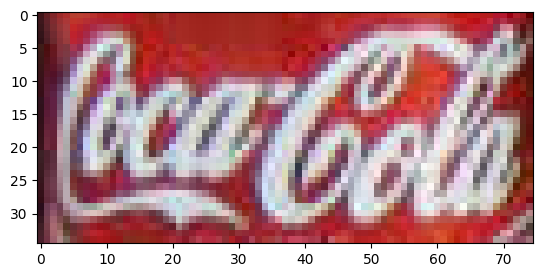

In [119]:
# Logo de menor encontrado en las imágenes
logo_menor = dict_imgs["bottles_plastic"][154:189,115:190,:]

plt.imshow(cv2.cvtColor(logo_menor, cv2.COLOR_BGR2RGB))

print(f"logo menor: h_{logo_menor.shape[0]}, w_{logo_menor.shape[1]}")

ratio_menor_img = round(logo_menor.shape[1] / dict_imgs["bottles_plastic"].shape[1], 3)
print(f"ratio logo-imagen: {ratio_menor_img}")

logo mayor: h_400, w_1155
ratio logo-imagen: 0.832


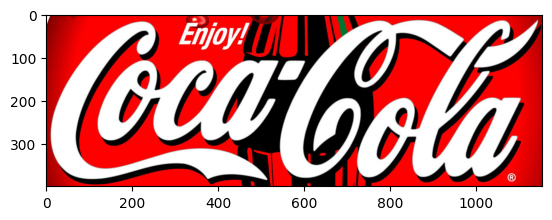

In [120]:
# Logo de mayor tamaño encontrado en las imágenes
logo_mayor = dict_imgs["logo"][470:870,95:1250,:]

plt.imshow(cv2.cvtColor(logo_mayor, cv2.COLOR_BGR2RGB))

print(f"logo mayor: h_{logo_mayor.shape[0]}, w_{logo_mayor.shape[1]}")

ratio_mayor_img = round(logo_mayor.shape[1] / dict_imgs["logo"].shape[1], 3)
print(f"ratio logo-imagen: {ratio_mayor_img}")

In [121]:
def get_scaled_templates(template, img, ratio_menor_img, ratio_mayor_img):
    ratio_template_img = template.shape[1] / img.shape[1]

    ratio_menor_template = ratio_menor_img / ratio_template_img
    ratio_mayor_template = ratio_mayor_img / ratio_template_img

    scales = np.linspace(ratio_menor_template, ratio_mayor_template, 15)

    scales_y = [1, 1.2, 1.4]

    list_templates = []
    for scale in scales:
        for scale_y in scales_y:
            list_templates.append(
                cv2.resize(template, None, fx=scale, fy=scale * scale_y)
            )

    return list_templates

---

In [128]:
methods = [
    "cv2.TM_CCOEFF",
    "cv2.TM_CCOEFF_NORMED",
    "cv2.TM_CCORR",
    "cv2.TM_CCORR_NORMED",
    "cv2.TM_SQDIFF",
    "cv2.TM_SQDIFF_NORMED",
]

meth = "cv2.TM_CCOEFF"
method = eval(meth)
current_image = "ad_retro"

list_shape = []
list_loc = []
list_val = []
list_templates = get_scaled_templates(
    template_border, dict_imgs_border[current_image], ratio_menor_img, ratio_mayor_img
)
for template in list_templates:
    template_too_tall = template.shape[0] > dict_imgs_border[current_image].shape[0]
    template_too_wide = template.shape[1] > dict_imgs_border[current_image].shape[1]
    if template_too_tall | template_too_wide:
        break

    res = cv2.matchTemplate(dict_imgs_border[current_image], template, method)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
        val = min_val
    else:
        top_left = max_loc
        val = max_val

    # Avg value per pixel to compare templates of different sizes
    if method not in [cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF_NORMED]:
        val = val / len(template.flatten())

    list_shape.append(template.shape[:2])
    list_loc.append(top_left)
    list_val.append(val)

In [129]:
# cv2 works with (x, y) | numpy works with (y, x)

list_annotated = []
for i, loc in enumerate(list_loc):
    img_salida = dict_imgs[current_image].copy()

    bottom_right = (loc[0] + list_shape[i][1], loc[1] + list_shape[i][0])
    cv2.rectangle(img_salida, loc, bottom_right, color=(0, 255, 0), thickness=10)

    list_annotated.append(img_salida)

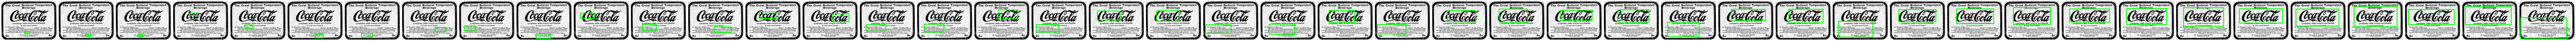

In [130]:
utils.plot_imgs(list_annotated, rows=1,  figsize=4)

In [131]:
list_templates[2].shape

(31, 67)

In [132]:
dict_imgs_border[current_image].shape

(493, 715)

In [133]:
# Problema encontrado: Cuando se usan tempaltes demasiado pequeños en imágenes con mucho texto. Ej. ad_retro.
# Podemos usar tamaños generales de template con tamaño en pixel. O podemos usar templates tamaño relativo a la imagen
# a analizar. Si usamos tamaño relativo tenemos im{agenes dónde el logo es sumamente pequeño, y eso hace que aparezcan
# tempaltes pequeños en otras imágenes que no los necesitan. Cómo evaluar los tamaños de template a usar?
list_val

[692.7797659430122,
 752.5203071182549,
 665.4824867597497,
 489.12380952380954,
 406.63205574912894,
 379.9669146825397,
 379.1785076625502,
 354.27765984015986,
 342.2734534696073,
 335.05783898305083,
 351.4615023474178,
 280.57508366800533,
 277.3719737512742,
 289.9149775976104,
 297.498876146789,
 288.6844075520833,
 276.6088528774753,
 266.34535256410254,
 284.72436717861206,
 281.47751891972104,
 246.1036531411958,
 249.9373873998725,
 235.91371136416453,
 240.1263316902528,
 280.57369705928465,
 249.43855714419215,
 224.5920847965876,
 251.1904144597948,
 432.9902093596059,
 192.97818814045993,
 257.72070529433546,
 228.6342084942085,
 207.75527733615968,
 341.66379536740374,
 261.96625900851717,
 198.8126020915867,
 421.11191204805624,
 275.51102965364913,
 178.30489918655928,
 239.24758905534136,
 191.49935646770453,
 180.93991247755835,
 208.6120060331825,
 182.56280973928034,
 174.49191368855233]